# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
batch_size = 32
img_height = 150
img_width = 150

# Loading Data

In [3]:
data_dir='/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [4]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [5]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


# Images

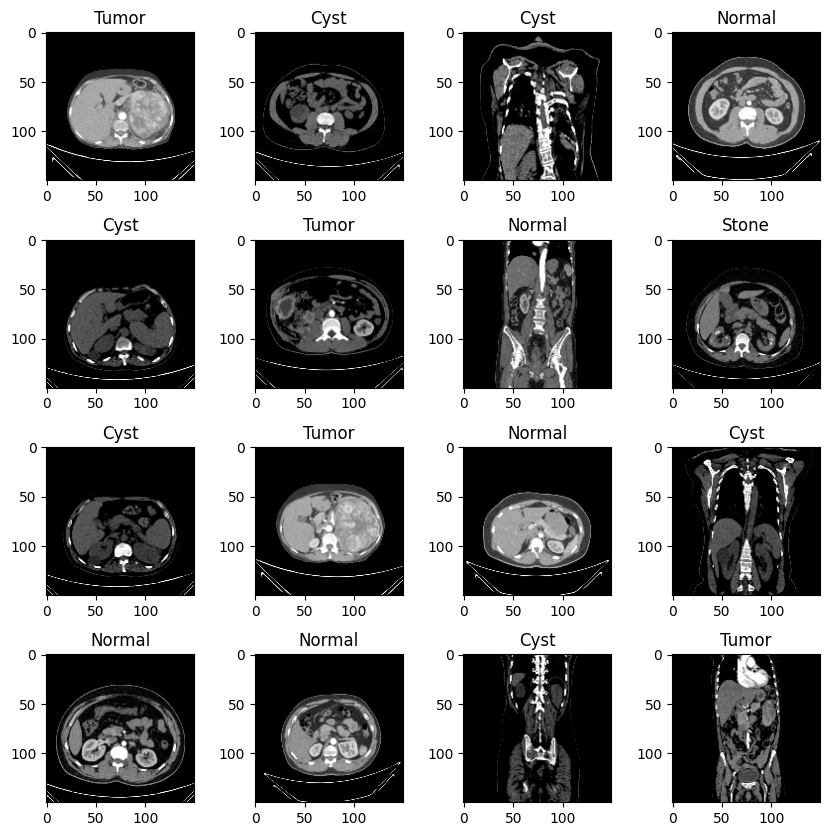

In [6]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [7]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# Training Models

**CNN Model**

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
epochs=15
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 39s 100ms/step - loss: 0.1154 - accuracy: 0.9621 - val_loss: 9.7389e-04 - val_accuracy: 1.0000
Epoch 2/15
351/351 [==============================] - 4s 13ms/step - loss: 4.1608e-04 - accuracy: 1.0000 - val_loss: 1.1931e-04 - val_accuracy: 1.0000
Epoch 3/15
351/351 [==============================] - 4s 13ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 5.4701e-05 - val_accuracy: 1.0000
Epoch 4/15
351/351 [==============================] - 4s 13ms/step - loss: 2.8955e-05 - accuracy: 1.0000 - val_loss: 2.9569e-05 - val_accuracy: 1.0000
Epoch 5/15
351/351 [==============================] - 4s 13ms/step - loss: 1.7119e-05 - accuracy: 1.0000 - val_loss: 1.9707e-05 - val_accuracy: 1.0000
Epoch 6/15
351/351 [==============================] - 5s 13ms/step - loss: 1.1781e-05 - accuracy: 1.0000 - val_loss: 1.4227e-05 - val_accuracy: 1.0000
Epoch 7/15
351/351 [==============================] - 4s 13ms/step - loss: 8.5419e-06 - accuracy: 1.

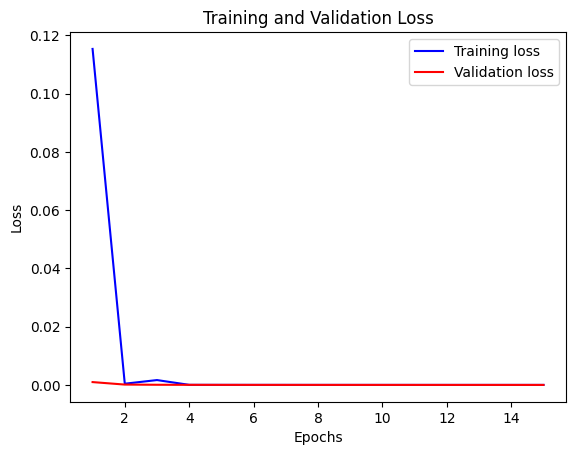

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

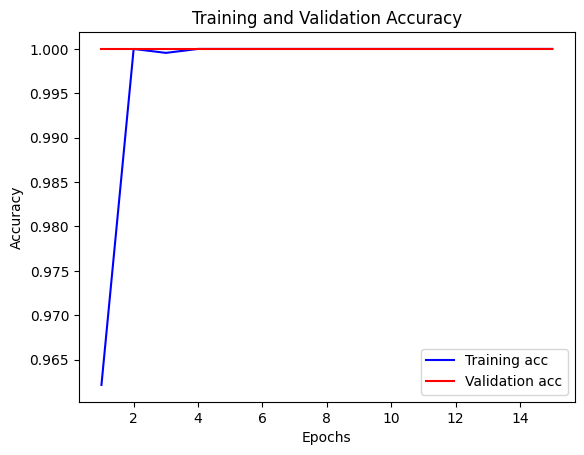

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

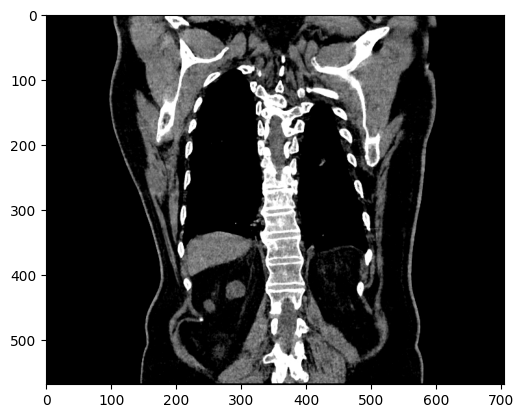

1/1 [==============================] - 0s 192ms/step


'Cyst'

In [14]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

**VGG16 Model**

In [15]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                      

In [18]:
epochs=15
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 20s 49ms/step - loss: 0.4660 - accuracy: 0.8274 - val_loss: 0.2376 - val_accuracy: 0.9096
Epoch 2/15
351/351 [==============================] - 16s 45ms/step - loss: 0.1721 - accuracy: 0.9420 - val_loss: 0.1575 - val_accuracy: 0.9542
Epoch 3/15
351/351 [==============================] - 16s 45ms/step - loss: 0.1281 - accuracy: 0.9572 - val_loss: 0.1052 - val_accuracy: 0.9695
Epoch 4/15
351/351 [==============================] - 16s 45ms/step - loss: 0.1049 - accuracy: 0.9668 - val_loss: 0.2328 - val_accuracy: 0.9084
Epoch 5/15
351/351 [==============================] - 16s 45ms/step - loss: 0.0899 - accuracy: 0.9702 - val_loss: 0.0522 - val_accuracy: 0.9883
Epoch 6/15
351/351 [==============================] - 16s 45ms/step - loss: 0.0849 - accuracy: 0.9714 - val_loss: 0.2071 - val_accuracy: 0.9209
Epoch 7/15
351/351 [==============================] - 16s 45ms/step - loss: 0.0779 - accuracy: 0.9741 - val_loss: 0.0477 - val_accuracy:

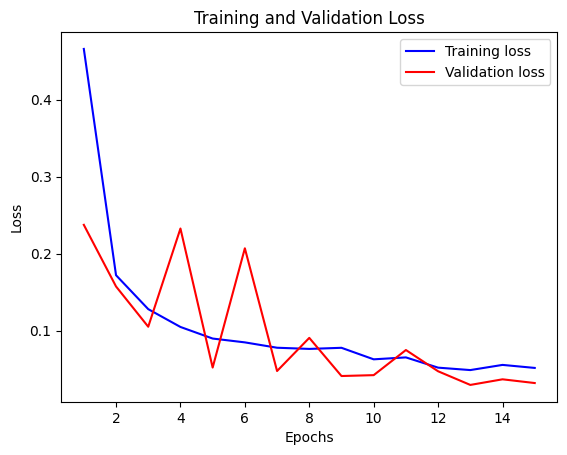

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

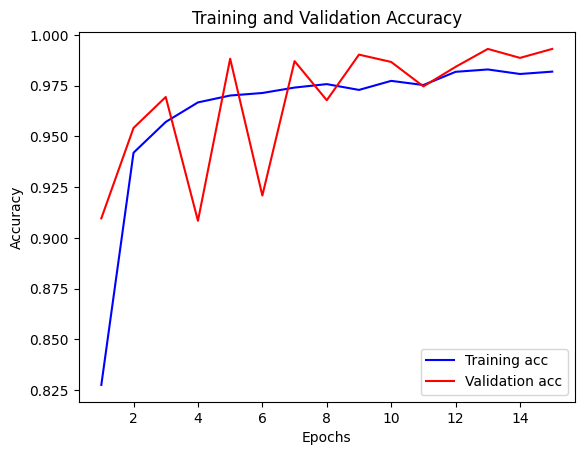

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

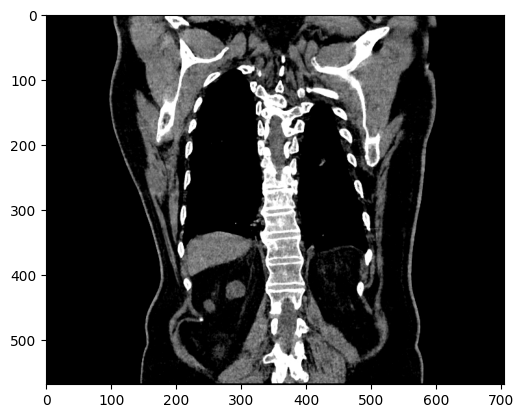

1/1 [==============================] - 0s 369ms/step


'Normal'

In [21]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

**MobileNet Model**

In [22]:
mobile_net = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


mobile_net.add(pretrained_model)
mobile_net.add(Flatten())
mobile_net.add(Dense(512, activation='relu'))
mobile_net.add(BatchNormalization())  # Batch Normalization layer
mobile_net.add(Dropout(0.5))

mobile_net.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
mobile_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [25]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 14s 26ms/step - loss: 0.4085 - accuracy: 0.8590 - val_loss: 0.1207 - val_accuracy: 0.9654
Epoch 2/15
351/351 [==============================] - 8s 22ms/step - loss: 0.1382 - accuracy: 0.9526 - val_loss: 0.0556 - val_accuracy: 0.9855
Epoch 3/15
351/351 [==============================] - 8s 22ms/step - loss: 0.0800 - accuracy: 0.9735 - val_loss: 0.0356 - val_accuracy: 0.9920
Epoch 4/15
351/351 [==============================] - 8s 22ms/step - loss: 0.0680 - accuracy: 0.9789 - val_loss: 0.0477 - val_accuracy: 0.9847
Epoch 5/15
351/351 [==============================] - 8s 21ms/step - loss: 0.0544 - accuracy: 0.9813 - val_loss: 0.1046 - val_accuracy: 0.9654
Epoch 6/15
351/351 [==============================] - 8s 22ms/step - loss: 0.0431 - accuracy: 0.9871 - val_loss: 0.0287 - val_accuracy: 0.9904
Epoch 7/15
351/351 [==============================] - 8s 22ms/step - loss: 0.0415 - accuracy: 0.9853 - val_loss: 0.0501 - val_accuracy: 0.984

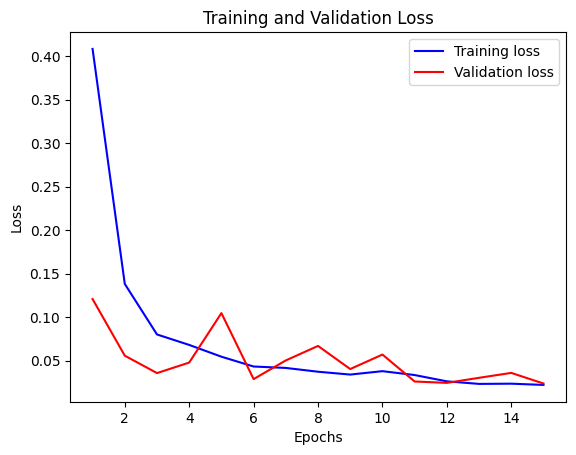

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

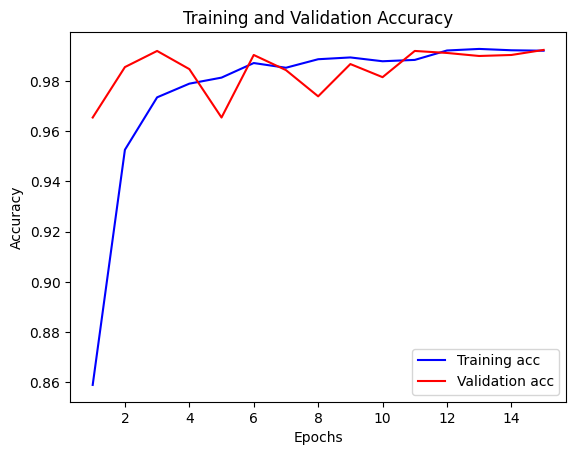

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

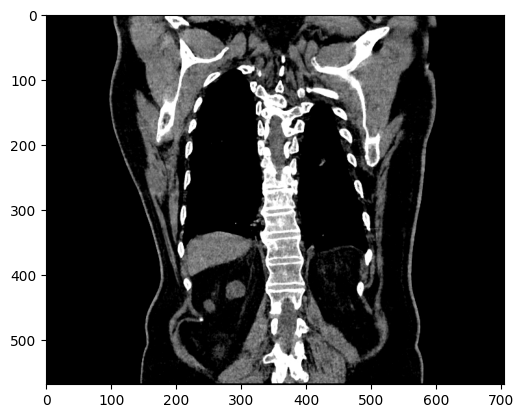

1/1 [==============================] - 1s 1s/step


'Cyst'

In [28]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

**From the visual representation in the above graphs MobileNet has a superior performance compared to both CNN and VGG16.**



In [29]:
mobile_net.save("model.h5")

In [30]:
loaded_model = tf.keras.models.load_model("/kaggle/working/model.h5")

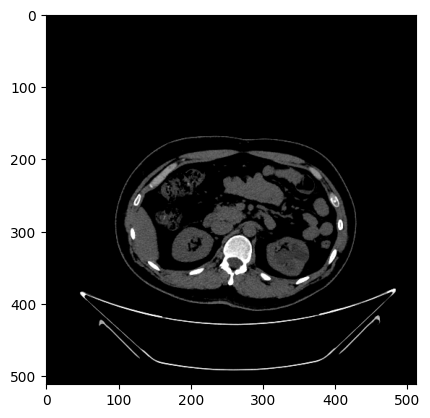

1/1 [==============================] - 1s 905ms/step


'Cyst'

In [31]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1000).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = loaded_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]